---
title: Introduction to Deep Reinforcement Learning
author: Mark Fuge
date: 'November 26 2025'
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---


In this chapter we will briefly review key reinforcement learning (RL) algorithms, and implement them on the Acrobot-v1 environment from the [Gymnasium library](https://gymnasium.farama.org/). Specifically, we will review the differences between value-based (sometimes called "Critic Methods") and policy-based methods (sometimes called "Actor Methods"), and we to demonstrate the differences, we will implement Deep Q-Networks (DQN), Policy Gradient (REINFORCE), Vanilla Actor-Critic (AC), and finally Proximal Policy Optimization.

## Learning Objectives
- Understand how value-based, policy-based, and actor-critic methods differ conceptually and algorithmically.
- Interpret diagnostic plots (learning curves, value plots, policy visualizations).
- Understand the strengths and weaknesses of each method on a common example.
- Gain intuition about fundamental parameters of each model (learning rate, discount factor, exploration rate, entropy regularization, etc.) and how they affect learning.

In [6]:
import math
import random
from typing import List, Tuple
from tqdm.auto import trange
from collections import deque

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F
from ipywidgets import interact, FloatSlider

sns.set_theme(context="talk", style="whitegrid")
plt.rcParams.update({"figure.figsize": (8, 4.5), "axes.titlesize": 14, "axes.labelsize": 12})
torch.set_default_dtype(torch.float32)

USE_GPU = False  # Toggle to True if you specifically want to benchmark CUDA.
DEVICE = torch.device("cuda" if USE_GPU and torch.cuda.is_available() else "cpu")
print(f"Using {DEVICE} (USE_GPU={USE_GPU})")

Using cpu (USE_GPU=False)


First let's take a look at the Acrobot-v1 environment:

In [7]:
ENV_ID = "Acrobot-v1"
env = gym.make(ENV_ID, render_mode="human")

print(f"The action space is {env.action_space}")
print(f"A sample action is: {env.action_space.sample()}")
print(f"The observation space is {env.observation_space}")
print(f"A sample observation is: {env.observation_space.sample()}")

The action space is Discrete(3)
A sample action is: 2
The observation space is Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
A sample observation is: [-0.5119918  -0.57492304  0.10808961  0.90896344 -3.5385666  15.979161  ]


We see that the goal of the agent is to swing the lower link up to a given height by applying torques at the joint between the two links, much like you would do with your own hips if you had to swing yourself upward while hanging on a bar. What is not obvious from the printed action/observation spaces and the environment render is that the agent receives a reward of -1 for each time step until it reaches the goal, encouraging it to reach the goal as quickly as possible. We can see this below by running a random policy (which shouldn't do too well) for several episodes and summing up the total rewards received.

In [8]:
#| code-fold: false
# Reset environment to start a new episode
observation, info = env.reset()

print(f"Starting observation: {observation}")

episode_over = False
total_reward = 0

for i in range(500):
    # Choose an action
    action = env.action_space.sample()  # Random action for now - real agents will be smarter!

    # Take the action and see what happens
    observation, reward, terminated, truncated, info = env.step(action)

    total_reward += reward
    episode_over = terminated or truncated

print(f"Episode finished! Total reward: {total_reward}")
env.close()

Starting observation: [ 0.99901444 -0.04438601  0.9955945  -0.09376328  0.00158421 -0.04944538]
Episode finished! Total reward: -500.0


## Deep Q-Network (DQN)

In Deep Q-Networks (DQN), we learn a state-action value function $Q(s, a)$ that estimates the expected return from taking action $a$ in state $s$ and following the current policy thereafter. The policy is derived from the Q-function by selecting the action with the highest estimated value, often with some exploration strategy like $\epsilon$-greedy, to prevent getting stuck in suboptimal policies. Specifically, a small MLP predicts $Q(s, a)$ a continuous space of angles and velocities, and then has to predict the Q-values for a discrete set of actions: applying positive torque, negative torque, or no torque. To select actions, the agent picks the action with the highest Q-value for the current state:
$$a_t = \arg\max_a Q_\theta(s_t, a).$$

To encourage exploration the policy is $\epsilon$-greedy, which means that it takes the Q-maximizing action with probability $1 - \epsilon$ and a random action with probability $\epsilon$.

To train the Q-function, we use the Bellman equation as a target for supervised learning:
$$y_t = r_t + \gamma \max_{a'} Q_\theta(s_{t+1}, a'),$$

where $r_t$ is the reward received after taking action $a_t$ in state $s_t$, and $\gamma$ is the discount factor that determines the importance of future rewards. The target $y_t$ represents the estimated return for taking action $a_t$ in state $s_t$. The Q-function parameters $\theta$ are updated to minimize the difference between the predicted Q-value and the target using mean-squared error loss. Specifically, we minimize the mean-squared Temporal Difference (TD) error:
$$\mathcal{L}_{\text{TD}} = \big(Q_\theta(s_t, a_t) - y_t\big)^2$$
typically using a variants of stochastic gradient descent, and over a batch of transitions sampled from a replay buffer to improve stability and sample efficiency.

In [9]:
#| code-fold: false
# Simple Discrete Deep Q-Network (DQN) Agent
class DQNAgent:
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 128, lr: float = 1e-3):
        self.q_network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        ).to(DEVICE)
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def select_action(self, state: np.ndarray, epsilon: float = 0.0) -> int:
        if random.random() < epsilon:
            return random.randint(0, self.q_network[-1].out_features - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        return q_values.argmax().item()

    def train(self, batch: List[Tuple[np.ndarray, int, float, np.ndarray, bool]], gamma: float):
        states, actions, rewards, next_states, dones = zip(*batch)

        states_tensor = torch.FloatTensor(states).to(DEVICE)
        actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(DEVICE)
        rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1).to(DEVICE)
        next_states_tensor = torch.FloatTensor(next_states).to(DEVICE)
        dones_tensor = torch.FloatTensor(dones).unsqueeze(1).to(DEVICE)

        current_q_values = self.q_network(states_tensor).gather(1, actions_tensor)
        with torch.no_grad():
            max_next_q_values = self.q_network(next_states_tensor).max(1)[0].unsqueeze(1)
            target_q_values = rewards_tensor + (gamma * max_next_q_values * (1 - dones_tensor))

        loss = self.criterion(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [10]:
#| code-fold: false
# Now we can instantiate the DQNAgent and use it to interact with Acrobot-v1 environment.
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n  # Ensure the action space is discrete for DQN
dqn_agent = DQNAgent(state_dim, action_dim)

In [ ]:
#| code-fold: false
# The main training loop for the DQN agent
def train_dqn_agent(env: gym.Env, agent: DQNAgent, num_episodes: int = 700, batch_size: int = 64,
                    gamma: float = 0.99, epsilon_start: float = 1.0, epsilon_end: float = 0.1,
                    epsilon_decay: float = 0.995, replay_buffer_size: int = 10000,
                    max_steps_per_episode: int = 500) -> List[float]:
    replay_buffer = deque(maxlen=replay_buffer_size)
    epsilon = epsilon_start
    all_rewards = []

    visited_states = set()
    for episode in trange(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        for step in range(max_steps_per_episode):
            action = agent.select_action(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            visited_states.add(tuple(state))
            replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            episode_reward += reward

            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                agent.train(batch, gamma)
            if done:
                break

        all_rewards.append(episode_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

    return all_rewards, visited_states

In [12]:
#| code-fold: false
env = gym.make('Acrobot-v1')
dqn_rewards, dqn_visited_states = train_dqn_agent(env, dqn_agent, num_episodes=300)

  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\mafuge\AppData\Local\Temp\ipykernel_1116\1304865866.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states_tensor = torch.FloatTensor(states).to(DEVICE)


In [13]:
def visualize_agent(agent, env):
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated
    print(f"Total reward during evaluation: {total_reward}")

In [ ]:
# Now that the agent is trained, we can visualize its behavior in the environment.
# env = gym.make('Acrobot-v1', render_mode="human")
# visualize_agent(dqn_agent, env)
# env.close()

Total reward during evaluation: -500.0


Beyond just visualizing the performance on a sample environment, we can also inspect several aspects of the model training, including:

1. **Learning Curves**: Plotting the average return over episodes to see how quickly the agent learns.
2. **Q-Value Estimates**: Visualizing the predicted Q-values for different states and actions to assess how well the model is learning the value function.
3. **Policy Visualization**: Showing the selected actions as a function of space to understand the agent's learned behavior.


In [15]:
# Plotting the Learning Curve
def plot_learning_curve(rewards: List[float], window: int = 10):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Episode Reward')
    if len(rewards) >= window:
        smoothed_rewards = pd.Series(rewards).rolling(window).mean()
        plt.plot(smoothed_rewards, label='Smoothed Reward', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Learning Curve on Acrobot-v1')
    plt.legend()
    plt.show()

# Map theta1 and theta2 to the Observation Space of Acrobot-v1 to visualize Q-values and policy
# This ignores the angular velocities for simplicity, although those obviously matter in practice.
def map_angles_to_state(theta1: float, theta2: float, v1=0.0, v2=0.0) -> np.ndarray:
    return np.array([math.cos(theta1), math.sin(theta1), math.cos(theta2), math.sin(theta2), v1, v2])

# Plot the Q-Value Estimates as a function of the two main angles theta1 and theta2
def plot_q_values(agent: DQNAgent, state_dim: int, num_points: int = 50, v1: float = 0.0, v2: float = 0.0):
    """
    Plot Q-value surfaces for each discrete action as a row of subplots.
    theta1 and theta2 are varied over [-pi, pi]; angular velocities v1, v2 are held fixed.
    """
    theta1_space = np.linspace(-math.pi, math.pi, num_points)
    theta2_space = np.linspace(-math.pi, math.pi, num_points)
    n_actions = agent.q_network[-1].out_features

    # Precompute Q-values for the grid of angles
    q_values = np.zeros((num_points, num_points, n_actions), dtype=float)
    for i, theta1 in enumerate(theta1_space):
        for j, theta2 in enumerate(theta2_space):
            state = map_angles_to_state(theta1, theta2, v1, v2)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                q_vals = agent.q_network(state_tensor).cpu().numpy().squeeze()
            q_values[i, j, :] = q_vals

    # Create a single-row of subplots, one per action
    fig, axes = plt.subplots(1, n_actions, figsize=(4 * n_actions, 5), sharex=True, sharey=True, constrained_layout=True)
    axes = np.atleast_1d(axes)

    for action in range(n_actions):
        ax = axes[action]
        # contourf expects X and Y as 1D arrays for axis ticks when passing Z as (M, N)
        im = ax.contourf(theta1_space, theta2_space, q_values[:, :, action], levels=50, cmap='viridis')
        fig.colorbar(im, ax=ax, label='Q-Value')
        ax.set_xlabel('Theta 1 (radians)')
        ax.set_ylabel('Theta 2 (radians)') if action == 0 else None
        ax.set_title(f'Q-Values for Action {action}')
        ax.set_aspect('auto')

    fig.suptitle('Q-Value Estimates Across Theta1/Theta2', fontsize=16)
    plt.show()

# Plot the policy as a function of the two main angles theta1 and theta2
def plot_dqn_policy(agent: DQNAgent, state_dim: int, num_points: int = 50, v1=0.0, v2=0.0):
    theta1_space = np.linspace(-math.pi, math.pi, num_points)
    theta2_space = np.linspace(-math.pi, math.pi, num_points)
    policy = np.zeros((num_points, num_points))

    for i, theta1 in enumerate(theta1_space):
        for j, theta2 in enumerate(theta2_space):
            state = map_angles_to_state(theta1, theta2, v1, v2)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                q_vals = agent.q_network(state_tensor)
            best_action = q_vals.argmax().item()
            policy[i, j] = best_action

    plt.figure(figsize=(8, 6))
    plt.contourf(theta1_space, theta2_space, policy, levels=agent.q_network[-1].out_features - 1, cmap='viridis')
    plt.colorbar(label='Best Action')
    plt.xlabel('Theta 1 (radians)')
    plt.ylabel('Theta 2 (radians)')
    plt.title('Policy Visualization')
    plt.show()

# Plot the states visted during training as a pairplot of both angles and velocities
def plot_visited_states(visited_states: set):
    df = pd.DataFrame(list(visited_states), columns=['cos_theta1', 'sin_theta1', 'cos_theta2', 'sin_theta2', 'theta1_dot', 'theta2_dot'])
    # Compute angles from cos and sin
    df['theta1'] = np.arctan2(df['sin_theta1'], df['cos_theta1'])
    df['theta2'] = np.arctan2(df['sin_theta2'], df['cos_theta2'])
    sns.pairplot(df[['theta1', 'theta2', 'theta1_dot', 'theta2_dot']], diag_kind='kde', plot_kws={'alpha': 0.2, 's': 10})
    plt.suptitle('Visited States During Training', y=1.02)
    plt.show()

# Interactive plots of the Q-values and policy with sliders for angular velocities:
def interactive_q_policy_plots(agent: DQNAgent, state_dim: int):
    @interact(v1=FloatSlider(min=-10.0, max=10.0, step=0.1, value=0.0),
              v2=FloatSlider(min=-10.0, max=10.0, step=0.1, value=0.0))
    def update(v1: float, v2: float):
        plot_q_values(agent, state_dim, v1=v1, v2=v2)
        plot_dqn_policy(agent, state_dim, v1=v1, v2=v2)

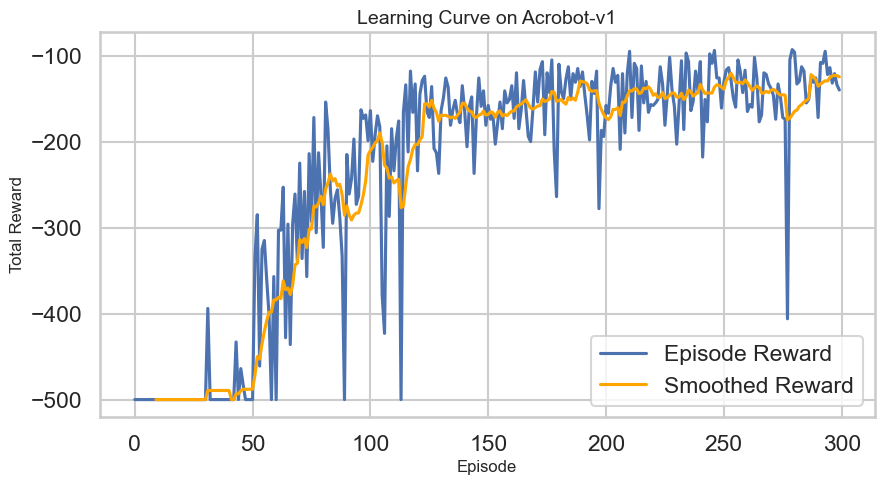

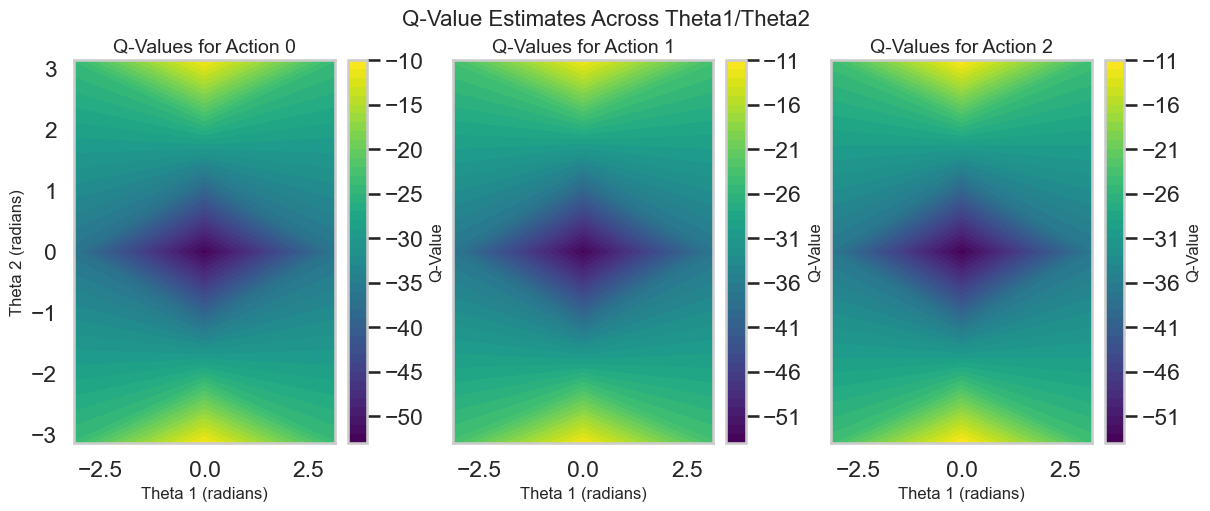

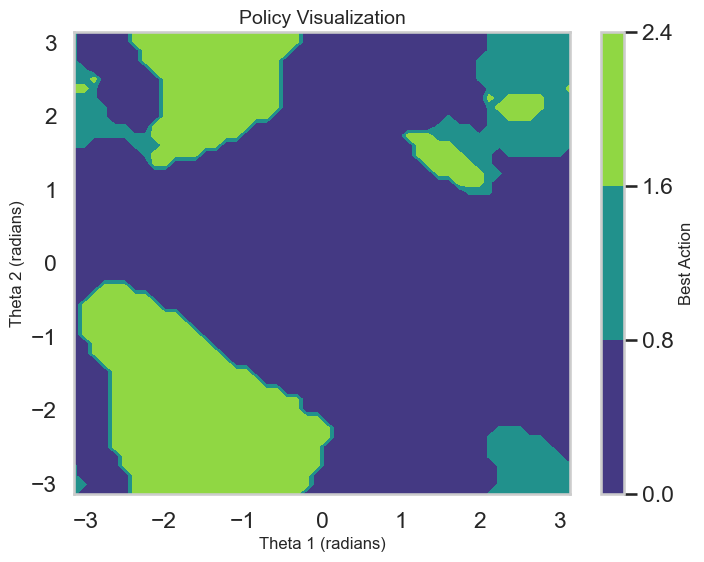

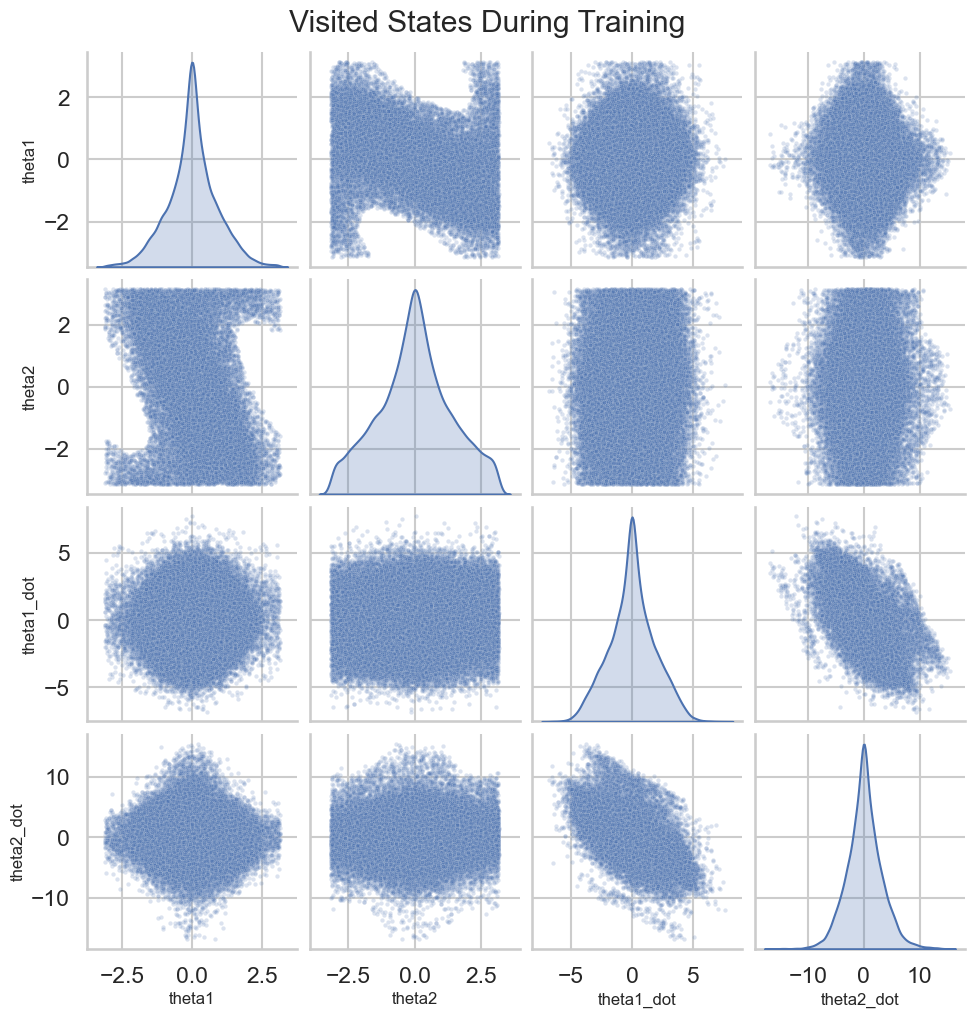

In [16]:
plot_learning_curve(dqn_rewards)
plot_q_values(dqn_agent, state_dim, action_dim)
plot_dqn_policy(dqn_agent, state_dim)
plot_visited_states(dqn_visited_states)

We can also interactively change the angular velocities to see how this updates the agent's q-value estimates and policy:

In [17]:
interactive_q_policy_plots(dqn_agent, state_dim)

interactive(children=(FloatSlider(value=0.0, description='v1', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

::: {.callout-tip appearance="default"}
### Experiment: Effect the DQN architecture and training parameters on performance

The behavior of the DQN depends heavily on the architecture of the neural network used to approximate the Q-function, as well as various training parameters. Here are some aspects to experiment with so that you can get an intuition for how they affect learning:

- **Network Architecture**: Try changing the number of layers and neurons in the MLP. A deeper or wider network may capture more complex patterns but could also lead to overfitting or instability -- what do you observe?
- **Discount Factor ($\gamma$)**: Experiment with different values of the discount factor. A higher $\gamma$ places more emphasis on future rewards, while a lower $\gamma$ focuses more on immediate rewards. How does this affect the learned policy? Start with it set to 0.99 and then decrement to values like 0.95, 0.90, etc. and note how this affects the Learning Curve plot.
- **Exploration Rate ($\epsilon$)**: Adjust the exploration rate in the $\epsilon$-greedy policy. A higher $\epsilon$ encourages more exploration, which can help discover better policies, but may also slow down learning. Try values like 0.1, 0.2, and 0.3 and see how quickly the agent learns. What if you set it to 0 (no exploration)? Could it improve learning to decay $\epsilon$ over time? If so, what possible downsides could you see to this?
- **Visited States versus Learned Policy**: After training, visualize the states visited during training versus the learned policy. Are there areas of the state space that the agent has not explored? Use the interactive visualization to look at the policy learned at this "out of distribution" set of states. What do you see?

:::



## Policy Gradients (REINFORCE)

In contrast to value-based methods like DQN, policy gradient methods directly optimize the policy $\pi_\theta(a|s)$ without relying on a value function. This has several advantages, including the ability to naturally handle continuous action spaces and stochastic policies. To do this, Policy Gradient methods optimize the expected return by adjusting the policy parameters $\theta$ in the direction that increases the likelihood of actions that lead to higher returns. It does this via the same Log-Derivative trick we learned about during Variational Inference, which allows us to express the gradient of a function under an Expectation (i.e., the expected return here) with respect to the policy parameters as an expectation over the policy itself:
$$ \nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \nabla_\theta \log \pi_\theta(a|s) R(\tau) \right], $$
where $R(\tau)$ is the total return from trajectory $\tau$.

In [27]:
#| code-fold: false
# Basic Policy Gradient (REINFORCE) Agent
class PolicyGradientAgent:
    """
    Basic REINFORCE policy gradient agent with optional entropy regularization.
    """
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 128,
                 lr: float = 1e-3, entropy_coef: float = 1e-3, normalize_rewards: bool = True):
        self.policy_network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        ).to(DEVICE)
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=lr)
        self.entropy_coef = entropy_coef
        self.normalize_rewards = normalize_rewards

    def select_action(self, state: np.ndarray) -> int:
        """
        Sample an action from the policy for a single state.
        """
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            action_probs = self.policy_network(state_tensor).squeeze(0).cpu().numpy()
        action = np.random.choice(len(action_probs), p=action_probs)
        return int(action)

    def train(self, trajectories: List[Tuple[np.ndarray, int, float]], gamma: float):
        """
        Train the policy using a single episode trajectory list of (state, action, reward).
        Adds entropy regularization to encourage exploration.
        """
        states, actions, rewards = zip(*trajectories)

        # Compute discounted returns
        discounted_rewards = []
        G = 0.0
        for r in reversed(rewards):
            G = r + gamma * G
            discounted_rewards.insert(0, G)
        returns = torch.FloatTensor(discounted_rewards).to(DEVICE)

        # Optionally normalize returns (helps training stability)
        if self.normalize_rewards:
            returns = (returns - returns.mean()) / (returns.std(unbiased=False) + 1e-8)

        states_tensor = torch.FloatTensor(np.vstack(states)).to(DEVICE)
        actions_tensor = torch.LongTensor(actions).to(DEVICE)

        # Use torch.distributions for stable log-probs and entropy
        action_probs = self.policy_network(states_tensor)
        dist = torch.distributions.Categorical(probs=action_probs)
        log_probs = dist.log_prob(actions_tensor)
        entropy = dist.entropy()

        # Policy loss with entropy regularization (we maximize both returns and entropy)
        policy_loss = -torch.mean(log_probs * returns) - self.entropy_coef * torch.mean(entropy)

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

In [28]:
#| code-fold: false
# Instantiate and train the Policy Gradient agent similarly to the DQN agent above.
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
pg_agent = PolicyGradientAgent(state_dim, action_dim, entropy_coef=1e-7)

In [29]:
#| code-fold: false
# Training loop for Policy Gradient Agent
def train_pg_agent(env: gym.Env, agent: PolicyGradientAgent, num_episodes: int = 700, gamma: float = 0.99,
                   max_steps_per_episode: int = 500) -> List[float]:
    all_rewards = []
    visited_states = set()

    for episode in trange(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        trajectory = []

        for step in range(max_steps_per_episode):
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            trajectory.append((state, action, reward))
            visited_states.add(tuple(state))
            state = next_state
            episode_reward += reward

            if done:
                break

        agent.train(trajectory, gamma)
        all_rewards.append(episode_reward)

    return all_rewards, visited_states

In [30]:
#| code-fold: false
env = gym.make('Acrobot-v1')
pg_rewards, pg_visted_states = train_pg_agent(env, pg_agent, num_episodes=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Like with DQN, we can visualize:
1. **Learning Curves**: Tracking the average return to evaluate learning progress.
2. **Policy Distribution**: Visualizing the action distributions for given states to see how the policy evolves.

However, note that unlike DQN, REINFORCE does not learn a value function, so we won't have Q-value estimates to visualize, just the learned policy.

In [35]:
# Plot the policy as a function of the two main angles theta1 and theta2
def plot_pg_policy(agent: PolicyGradientAgent, state_dim: int, num_points: int = 50, v1=0.0, v2=0.0):
    theta1_space = np.linspace(-math.pi, math.pi, num_points)
    theta2_space = np.linspace(-math.pi, math.pi, num_points)
    policy = np.zeros((num_points, num_points))

    for i, theta1 in enumerate(theta1_space):
        for j, theta2 in enumerate(theta2_space):
            state = map_angles_to_state(theta1, theta2, v1, v2)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                action_probs = agent.policy_network(state_tensor)
            best_action = action_probs.argmax().item()
            policy[i, j] = best_action

    plt.figure(figsize=(8, 6))
    plt.contourf(theta1_space, theta2_space, policy, levels=agent.policy_network[-2].out_features - 1, cmap='viridis')
    plt.colorbar(label='Best Action')
    plt.xlabel('Theta 1 (radians)')
    plt.ylabel('Theta 2 (radians)')
    plt.title('Policy Visualization')
    plt.show()

# Interactive plots of the PG policy with sliders for angular velocities:
def interactive_pg_policy_plots(agent: PolicyGradientAgent, state_dim: int):
    @interact(v1=FloatSlider(min=-5.0, max=5.0, step=0.1, value=0.0),
              v2=FloatSlider(min=-5.0, max=5.0, step=0.1, value=0.0))
    def update(v1: float, v2: float):
        plot_pg_policy(agent, state_dim, v1=v1, v2=v2)

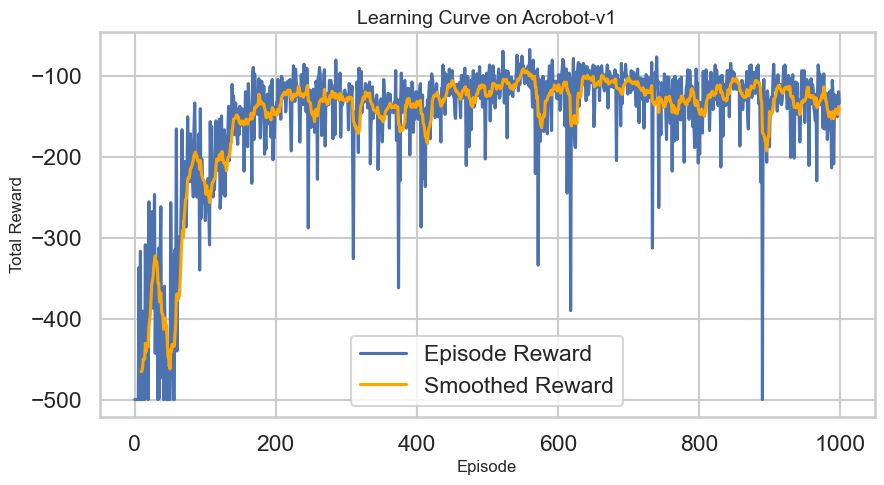

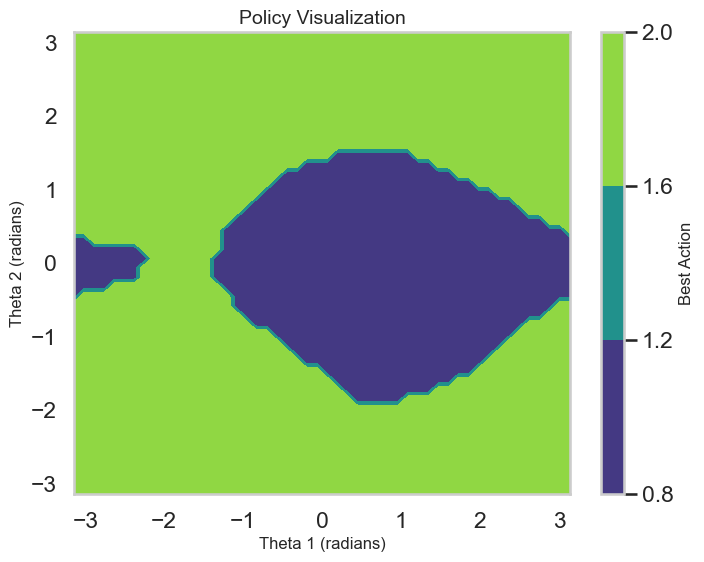

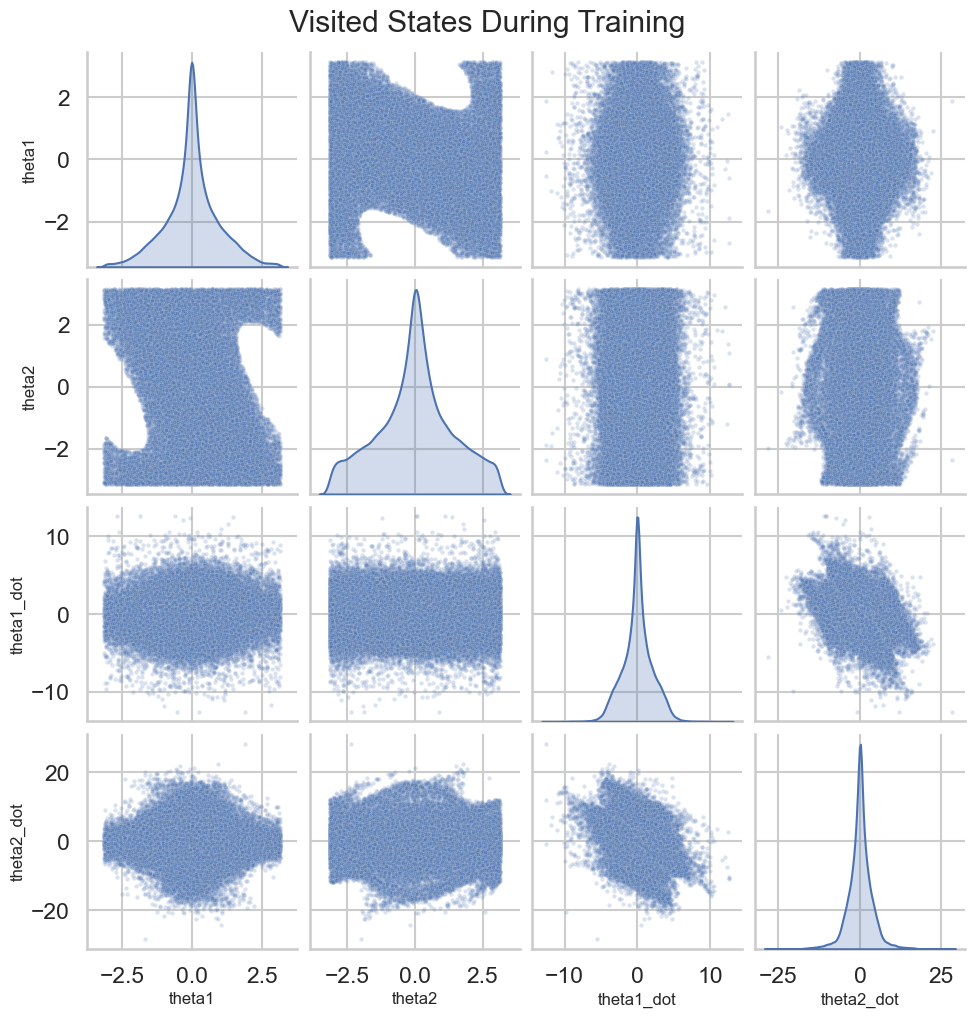

In [36]:
plot_learning_curve(pg_rewards)
plot_pg_policy(pg_agent, state_dim)
plot_visited_states(pg_visted_states)

We can also interactively change the angular velocities like before to see how this updates the agent's policy:

In [37]:
interactive_pg_policy_plots(pg_agent, state_dim)

interactive(children=(FloatSlider(value=0.0, description='v1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

In [38]:
# # Now that the agent is trained, we can visualize its behavior in the environment.
# env = gym.make('Acrobot-v1', render_mode="human")
# visualize_agent(pg_agent, env)
# env.close()

::: {.callout-tip appearance="default"}
### Experiment: Effect of PG architecture and training parameters on performance

While Policy Gradient methods do not rely on a value function, the architecture of the policy network and training parameters still play a crucial role in learning. Here are some aspects you can experiment with to gain some intution:

- **Network Architecture**: As with before, you can try modifying the MLP. As you do this, what do you observe? Pay particular attention to the variability in the learning curve and also how it affects the overall policy visualization.
- **Entropy Regularization**: We added an entropy bonus to the policy loss to encourage exploration and hopefully prevent the policy from collapsing into a suboptimal mode. Experiment with different weights for this bonus. A higher weight encourages more exploration, while a lower weight focuses more on exploitation of the current policy. How does this affect learning and the learned policy? What happens if you set it to zero? What about a very high value? How does this compare to your experiments above with the DQN parameter that controlled exploration in its case (e.g., $\epsilon$ in the $\epsilon$-greedy policy)? How does this affect the pairplot of the visited states during training?
- **Visited States versus Learned Policy**: As we did with the DQN, compare the learned policy using the interactive visualization with the states visted by the PG Agent. What do you see, especially in comparison to the DQN agent and as you move outside of the visited states?

:::



## Vanilla Actor-Critic (AC)

While Policy Gradient methods like REINFORCE are powerful, they can suffer from high variance in their gradient estimates, which can slow down learning. This is because they rely solely on sampled returns to estimate the expected return, which can be noisy, especially in environments with high variability, long horizons, or sparse rewards. Moreover, in environments where rewards differ significantly across states and actions, the variance can be exacerbated, making it difficult for the policy to converge to an optimal solution.

To address these issues, researchers developed Actor-Critic methods, which combine the strengths of both value-based and policy-based approaches. The main idea behind Actor-Critic methods is to use a value function (the critic) to provide a more stable estimate of the expected return, which can then be used to guide the policy updates (the actor). This helps reduce the variance of the policy gradient estimates while still allowing for direct optimization of the policy. In this way, the actor policy only needs to learn the relative advantages of actions, rather than their absolute returns, which can be easier and more stable. This is referred to as learning the "advantage function," which measures how much better an action is compared to the average action in a given state. By normalizing the returns in this way, Actor-Critic methods can in principle achieve lower variance in their gradient estimates, leading to more stable and efficient learning.

Specifically, Actor-Critic methods use two function approximators: one for the policy $\pi_\theta(a|s)$ (the actor) and another for the value function $V_\phi(s)$ (the critic). The Actor-Critic combines value-based bootstrapping (like in Value Iteration) with policy gradients. With TD(0), the critic target is
$$y_t = r_t + \gamma V_{\phi}(s_{t+1}).$$
The advantage estimate is $A_t = y_t - V_{\phi}(s_t)$ and the critic minimizes
$$\mathcal{L}_{\text{critic}} = (V_{\phi}(s_t) - y_t)^2.$$
The actor update uses $\nabla\log \pi_\theta(a_t|s_t) A_t$, which we can understand intuitively as increasing the log-probability of actions that lead to higher-than-expected returns (positive advantage) and decreasing it for actions that lead to lower-than-expected returns (negative advantage).

In [39]:
#| code-fold: false
# Vanilla Actor-Critic Agent with Entropy Regularization
class ActorCriticAgent:
    """
    Simple actor-critic agent with separate policy and value networks.
    Uses TD(0) bootstrapping for the critic and a policy gradient update
    for the actor. Adds entropy regularization to the policy loss to
    encourage exploration.
    """
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 128,
                 lr: float = 1e-3, entropy_coef: float = 1e-3):
        self.policy_network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        ).to(DEVICE)

        self.value_network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        ).to(DEVICE)

        self.policy_optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=lr)
        # give the value network a slightly larger LR by default (optional)
        self.value_optimizer = torch.optim.Adam(self.value_network.parameters(), lr=lr * 3)

        self.entropy_coef = entropy_coef

    def select_action(self, state: np.ndarray) -> int:
        """
        Sample an action from the policy for a single state (used during interaction).
        Returns:
            action (int): sampled discrete action
        """
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            action_probs = self.policy_network(state_tensor).squeeze(0)
        dist = torch.distributions.Categorical(probs=action_probs)
        action = dist.sample().item()
        return int(action)

    def train(self, trajectories: List[Tuple[np.ndarray, int, float, np.ndarray, bool]], gamma: float):
        """
        Perform one update of the actor and critic from a single episode trajectory.
        trajectories: list of (state, action, reward, next_state, done)
        """
        if len(trajectories) == 0:
            return

        states, actions, rewards, next_states, dones = zip(*trajectories)

        states_tensor = torch.FloatTensor(np.vstack(states)).to(DEVICE)
        actions_tensor = torch.LongTensor(actions).to(DEVICE)
        rewards_tensor = torch.FloatTensor(rewards).to(DEVICE)
        next_states_tensor = torch.FloatTensor(np.vstack(next_states)).to(DEVICE)
        dones_tensor = torch.FloatTensor(dones).to(DEVICE)

        # Compute TD(0) targets for the critic (handle terminal states)
        with torch.no_grad():
            next_state_values = self.value_network(next_states_tensor).squeeze(1)
            targets = rewards_tensor + gamma * next_state_values * (1.0 - dones_tensor)

        # Update value network (critic)
        values = self.value_network(states_tensor).squeeze(1)
        value_loss = F.mse_loss(values, targets)

        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

        # Update policy network (actor) with entropy regularization
        action_probs = self.policy_network(states_tensor)
        dist = torch.distributions.Categorical(probs=action_probs)
        log_probs = dist.log_prob(actions_tensor)
        entropy = dist.entropy()

        # Advantage: TD error (target - baseline)
        advantages = (targets - values).detach()

        policy_loss = -torch.mean(log_probs * advantages) - self.entropy_coef * torch.mean(entropy)

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

In [40]:
#|code-fold: false
# Training loop for Actor-Critic Agent
def train_ac_agent(env: gym.Env, agent: ActorCriticAgent, num_episodes: int = 700, gamma: float = 0.99,
                   max_steps_per_episode: int = 500) -> List[float]:
    all_rewards = []
    visited_states = set()

    for episode in trange(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        trajectory = []

        for step in range(max_steps_per_episode):
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            trajectory.append((state, action, reward, next_state, done))
            visited_states.add(tuple(state))
            state = next_state
            episode_reward += reward

            if done:
                break

        agent.train(trajectory, gamma)
        all_rewards.append(episode_reward)

    return all_rewards, visited_states

In [41]:
#| code-fold: false
env = gym.make('Acrobot-v1')
ac_agent = ActorCriticAgent(state_dim, action_dim, lr=5e-5, entropy_coef=5e-3)
ac_rewards, ac_visited_states = train_ac_agent(env, ac_agent, num_episodes=300, max_steps_per_episode=1000)

  0%|          | 0/300 [00:00<?, ?it/s]

In [42]:
# Plot the value network as a function of the two main angles theta1 and theta2 similar to the q_value plot above
def plot_value_function(agent: ActorCriticAgent, state_dim: int, num_points: int = 50, v1=0.0, v2=0.0):
    theta1_space = np.linspace(-math.pi, math.pi, num_points)
    theta2_space = np.linspace(-math.pi, math.pi, num_points)
    value_function = np.zeros((num_points, num_points))

    for i, theta1 in enumerate(theta1_space):
        for j, theta2 in enumerate(theta2_space):
            state = map_angles_to_state(theta1, theta2, v1, v2)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                value = agent.value_network(state_tensor).item()
            value_function[i, j] = value

    plt.figure(figsize=(8, 6))
    plt.contourf(theta1_space, theta2_space, value_function, levels=50, cmap='viridis')
    plt.colorbar(label='State Value')
    plt.xlabel('Theta 1 (radians)')
    plt.ylabel('Theta 2 (radians)')
    plt.title('Value Function Visualization')
    plt.show()

# Interactive plots of the PG policy with sliders for angular velocities:
def interactive_ac_policy_plots(agent: PolicyGradientAgent, state_dim: int):
    @interact(v1=FloatSlider(min=-5.0, max=5.0, step=0.1, value=0.0),
              v2=FloatSlider(min=-5.0, max=5.0, step=0.1, value=0.0))
    def update(v1: float, v2: float):
        plot_pg_policy(agent, state_dim, v1=v1, v2=v2)

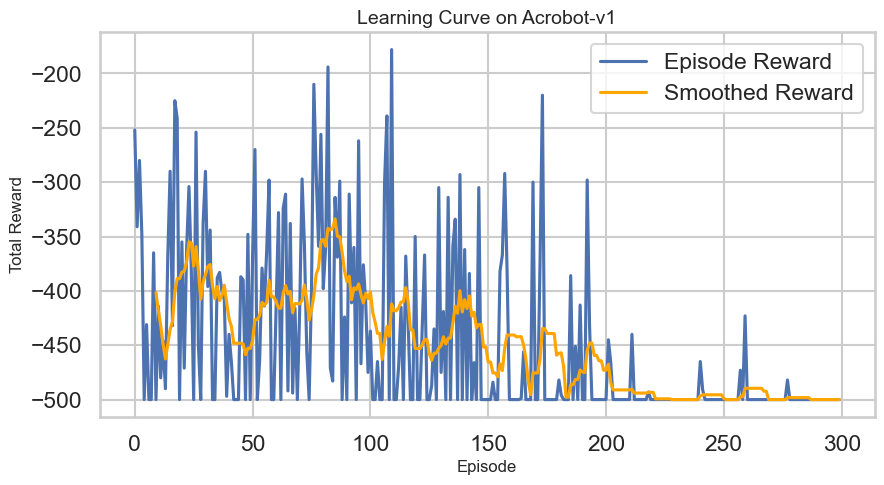

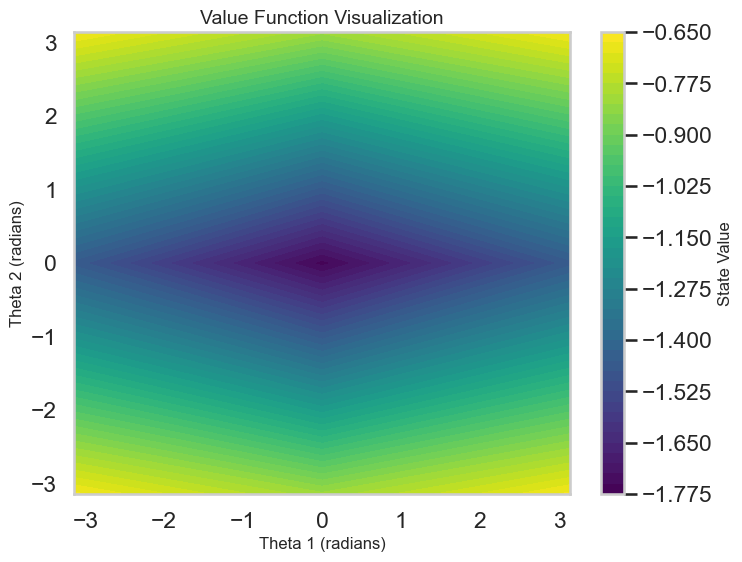

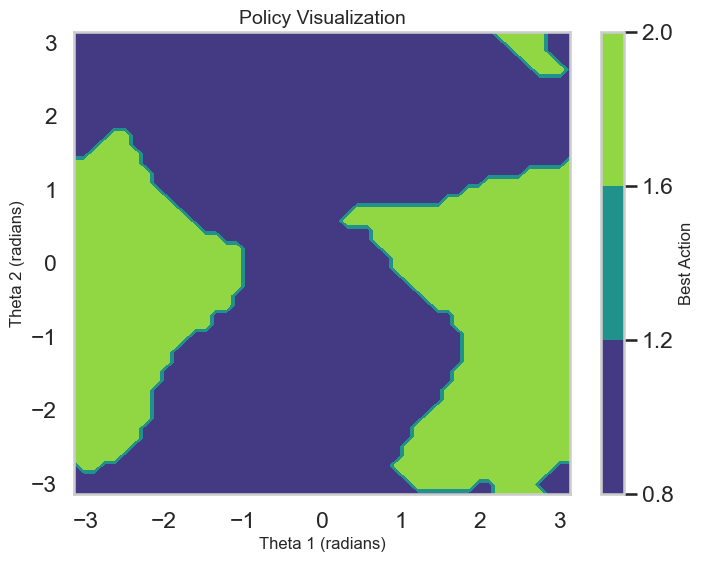

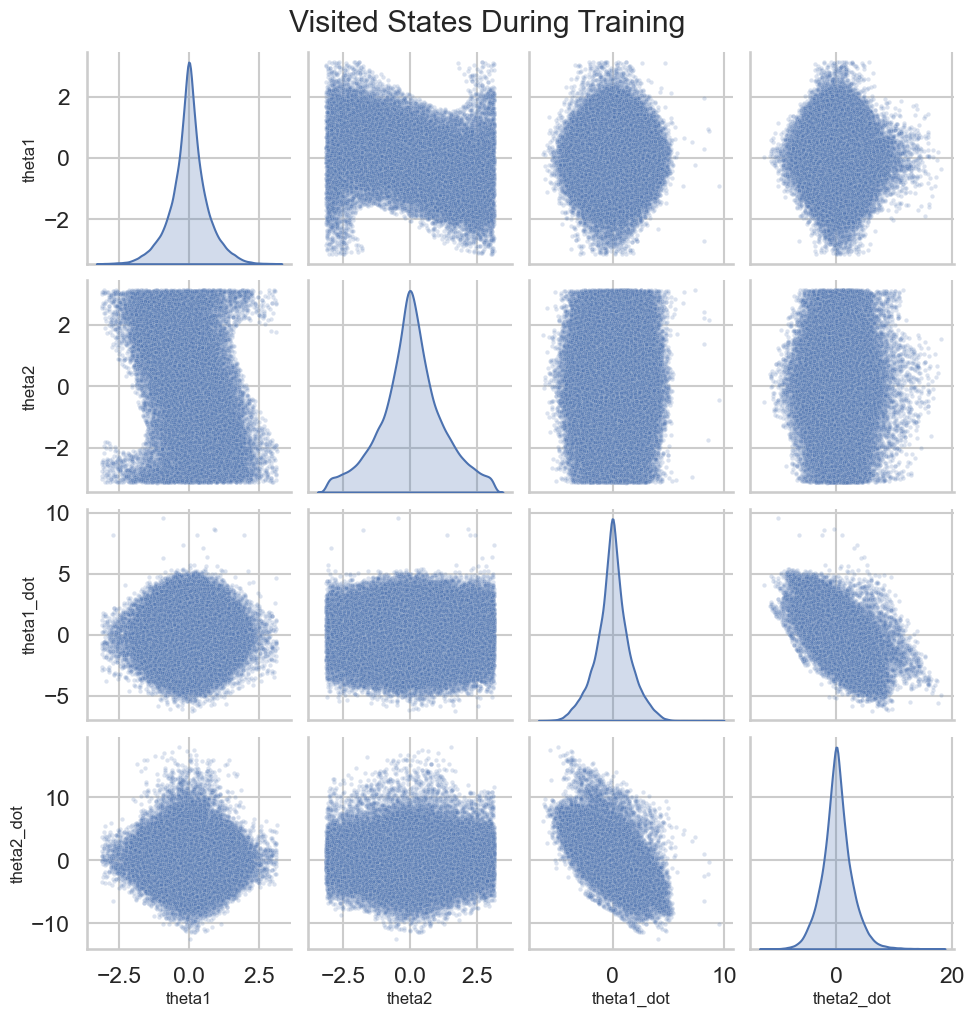

In [43]:
plot_learning_curve(ac_rewards)
plot_value_function(ac_agent, state_dim, action_dim)
plot_pg_policy(ac_agent, state_dim)
plot_visited_states(ac_visited_states)

In [44]:
# Interactive plots of the PG policy with sliders for angular velocities:
def interactive_ac_plots(agent: PolicyGradientAgent, state_dim: int):
    @interact(v1=FloatSlider(min=-5.0, max=5.0, step=0.1, value=0.0),
              v2=FloatSlider(min=-5.0, max=5.0, step=0.1, value=0.0))
    def update(v1: float, v2: float):
        plot_value_function(agent, state_dim, v1=v1, v2=v2)
        plot_pg_policy(agent, state_dim, v1=v1, v2=v2)

interactive_ac_plots(ac_agent, state_dim)

interactive(children=(FloatSlider(value=0.0, description='v1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

In [45]:
# Now that the agent is trained, we can visualize its behavior in the environment.
# env = gym.make('Acrobot-v1', render_mode="human")
# visualize_agent(ac_agent, env)
# env.close()

As we see above, while in principle Actor-Critic methods should have lower variance than pure policy gradient methods, in practice they can still suffer from instability due to the interaction between the actor and critic updates, much in the same way as we saw GANS struggle in an early chapter. For example, if the critic provides poor value estimates, it can lead to suboptimal policy updates, which in turn can degrade the quality of the value estimates (since the critic thinks a state is bad when it is really just following a bad policy). To mitigate these issues, various techniques such as target networks, experience replay, and entropy regularization are often employed, but in their basic form, Actor-Critic methods can still be sensitive to hyperparameters and require careful tuning.

::: {.callout-tip appearance="default"}
### Experiment: Effect of AC architecture and training parameters on performance

As mentioned above, the behavior of the Vanilla Actor-Critic can be difficult to tune due to the interaction between the actor and critic. Here are some aspects you can experiment with to gain some intution:

- **Relative Strength of the Critic versus Actor Updates**: Try adjusting the learning rates for the actor and critic separately. A higher learning rate for the critic may lead to faster value function updates, but could also destabilize the policy updates if the value estimates become too noisy. Conversely, a higher learning rate for the actor may lead to more aggressive policy updates, but could also result in suboptimal policies if the value estimates are not accurate enough. Experiment with different combinations of learning rates and observe how they affect the learning curve and the learned policy. Typically, starting with a higher learning rate for the critic compared to the actor can help stabilize learning -- you can compare this to your own observations.
- **Entropy Regularization**: As with the Policy Gradient method, we added an entropy bonus to the policy loss to encourage exploration and hopefully prevent the policy from collapsing into a suboptimal mode. Experiment with different weights for this bonus. A higher weight encourages more exploration, while a lower weight focuses more on exploitation of the current policy. How does this affect learning and the learned policy? What happens if you set it to zero? What about a very high value? How does this compare to your experiments above with the DQN and PG agents?
- **Learning Collapse**: Monitor the learning curves for signs of collapse or divergence. If you observe instability, try adjusting the learning rates, entropy regularization weight, or even the network architectures for the actor and critic. What combinations seem to work best for stabilizing learning in this environment? How sensitive is this Vanilla AC method to these hyperparameters compared to the DQN and PG methods you experimented with earlier?

:::



## Proximal Policy Optimization (PPO)

Building on the original idea of Actor-Critic methods, Proximal Policy Optimization (PPO), which (as of writing) is one of the most widely used Deep RL methods, introduces several enhancements to improve stability and performance. One of the key innovations in PPO is the use of a clipped surrogate objective to limit the size of policy updates, preventing large, destabilizing changes to the policy. This is achieved by defining a ratio of the new policy to the old policy:
$$
r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)}
$$

and then clipping this ratio to be within a specified range (typically $[1 - \epsilon, 1 + \epsilon]$) when computing the policy loss. This prevents the policy from changing too much in a single update, which could lead to instability in the Vanilla AC case above. The PPO objective can be expressed as:
$$
\mathcal{L}_{\text{PPO}}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) A_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t \right) \right]
$$

where $A_t$ is the advantage estimate, similar to that used in Vanilla Actor--Critic methods. Breaking the above formula down, we see that if the policy update would lead to a large increase in the probability of taking action $a_t$ (i.e., $r_t(\theta) > 1 + \epsilon$), the clipped term limits the contribution of that action to the loss, effectively preventing the policy from changing too much. Similarly, if the update would lead to a large decrease in the probability (i.e., $r_t(\theta) < 1 - \epsilon$), the clipping also limits the impact of that action on the loss. By taking the minimum of the unclipped and clipped objectives, PPO ensures that the policy update is conservative, leading to more stable learning.

The $r_t(\theta) A_t$ term encourages the policy to increase the probability of actions with positive advantage and decrease the probability of actions with negative advantage, similar to the Vanilla AC update, and the $\pi_{\theta_{\text{old}}}(a_t|s_t)$ term in $r_t(\theta)$ ensures that the updates are made relative to the previous policy, maintaining a connection to the past behavior of the agent.

In [46]:
#| code-fold: false
# Proximal Policy Optimization (PPO) Agent
class PPOAgent:
    """
    Proximal Policy Optimization (PPO) agent with clipped surrogate objective.
    Uses separate policy and value networks.
    """
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 128,
                 lr: float = 3e-4, clip_epsilon: float = 0.2, entropy_coef: float = 1e-3):
        self.policy_network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        ).to(DEVICE)

        self.value_network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        ).to(DEVICE)

        self.policy_optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=lr)
        self.value_optimizer = torch.optim.Adam(self.value_network.parameters(), lr=lr)

        self.clip_epsilon = clip_epsilon
        self.entropy_coef = entropy_coef
    def select_action(self, state: np.ndarray) -> Tuple[int, float]:
        """ Sample an action from the policy for a single state.
        Returns:
            action (int): sampled discrete action
            action_prob (float): probability of the sampled action
        """
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            action_probs = self.policy_network(state_tensor).squeeze(0)
        dist = torch.distributions.Categorical(probs=action_probs)
        action = dist.sample().item()
        action_prob = action_probs[action].item()
        return int(action)
    
    def train(self, trajectories: List[Tuple[np.ndarray, int, float, np.ndarray, bool]], gamma: float,
              ppo_epochs: int = 4, batch_size: int = 64):
        """
        Perform multiple PPO updates from a single episode trajectory.
        trajectories: list of (state, action, reward, next_state, done)
        """ 
        if len(trajectories) == 0:
            return
        states, actions, rewards, next_states, dones = zip(*trajectories)
        
        states_tensor = torch.FloatTensor(np.vstack(states)).to(DEVICE)
        actions_tensor = torch.LongTensor(actions).to(DEVICE)
        rewards_tensor = torch.FloatTensor(rewards).to(DEVICE)
        next_states_tensor = torch.FloatTensor(np.vstack(next_states)).to(DEVICE)
        dones_tensor = torch.FloatTensor(dones).to(DEVICE)
        
        # Compute TD(0) targets for the critic
        with torch.no_grad():
            next_state_values = self.value_network(next_states_tensor).squeeze(1)
            targets = rewards_tensor + gamma * next_state_values * (1.0 - dones_tensor)
        values = self.value_network(states_tensor).squeeze(1)
        advantages = (targets - values).detach()
        
        # Store old action probabilities
        with torch.no_grad():
            action_probs = self.policy_network(states_tensor)
            dist = torch.distributions.Categorical(probs=action_probs)
            old_log_probs = dist.log_prob(actions_tensor)
        
        dataset_size = len(trajectories)
        for _ in range(ppo_epochs):
            for start in range(0, dataset_size, batch_size):
                end = start + batch_size
                batch_indices = slice(start, end)
                batch_states = states_tensor[batch_indices]
                batch_actions = actions_tensor[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                
                # Update value network (critic)
                batch_values = self.value_network(batch_states).squeeze(1)
                batch_targets = targets[batch_indices]
                value_loss = F.mse_loss(batch_values, batch_targets)
                self.value_optimizer.zero_grad()
                value_loss.backward()
                self.value_optimizer.step()
                
                # Update policy network (actor) with PPO clipped objective
                action_probs = self.policy_network(batch_states)
                dist = torch.distributions.Categorical(probs=action_probs)
                log_probs = dist.log_prob(batch_actions)
                entropy = dist.entropy()
                
                ratios = torch.exp(log_probs - batch_old_log_probs)
                surr1 = ratios * batch_advantages
                surr2 = torch.clamp(ratios, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon) * batch_advantages
                
                policy_loss = -torch.mean(torch.min(surr1, surr2)) - self.entropy_coef * torch.mean(entropy)
                
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                self.policy_optimizer.step()

# Training loop for PPO Agent
def train_ppo_agent(env: gym.Env, agent: PPOAgent, num_episodes: int = 700, gamma: float = 0.99,
                    max_steps_per_episode: int = 500) -> List[float]:
    all_rewards = []
    visited_states = set()
    
    for episode in trange(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        trajectory = []
        for step in range(max_steps_per_episode):
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            trajectory.append((state, action, reward, next_state, done))
            visited_states.add(tuple(state))
            state = next_state
            episode_reward += reward
            if done:
                break
        agent.train(trajectory, gamma)
        all_rewards.append(episode_reward)
    return all_rewards, visited_states

In [47]:
#| code-fold: false
env = gym.make('Acrobot-v1')
ppo_agent = PPOAgent(state_dim, action_dim, lr=1e-3, clip_epsilon=0.2, entropy_coef=1e-3)
ppo_rewards, ppo_visited_states = train_ppo_agent(env, ppo_agent, num_episodes=600, max_steps_per_episode=1000)

  0%|          | 0/600 [00:00<?, ?it/s]

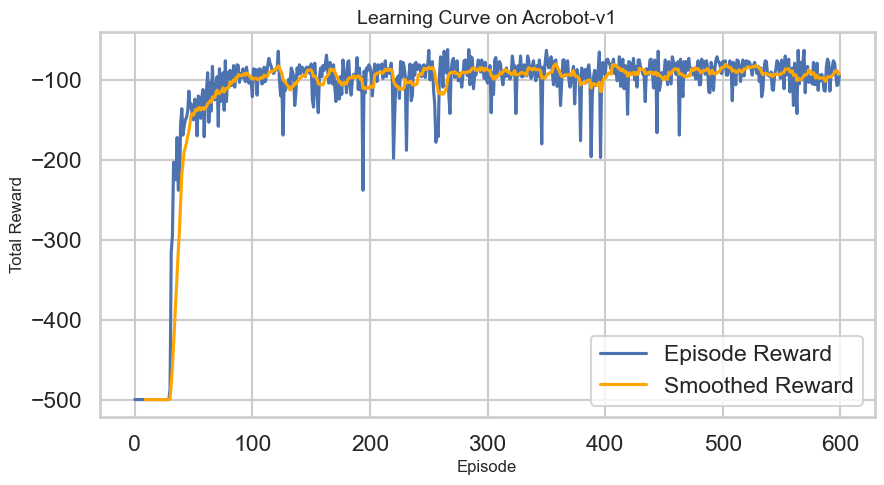

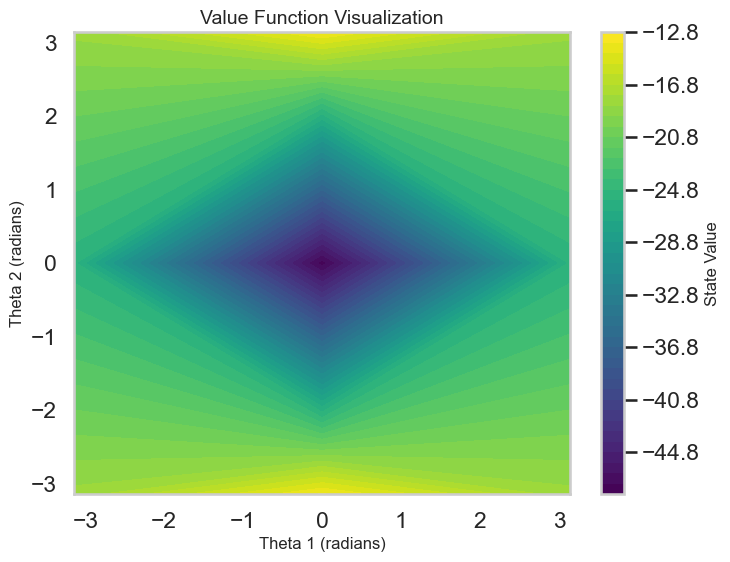

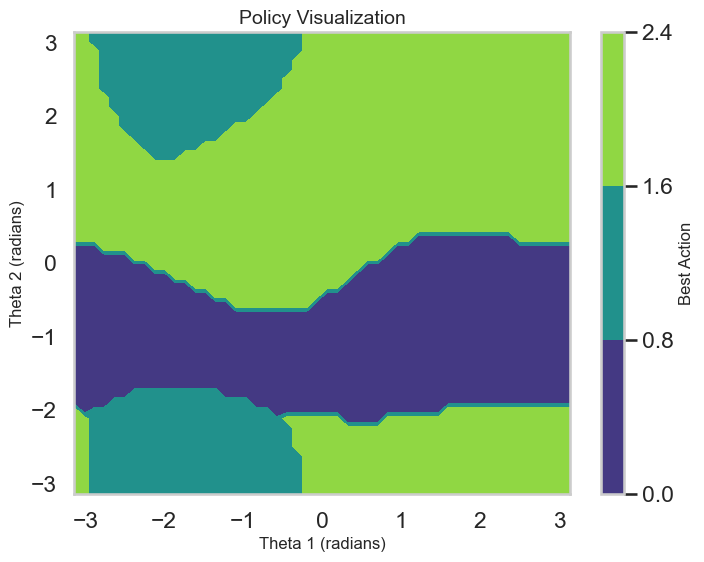

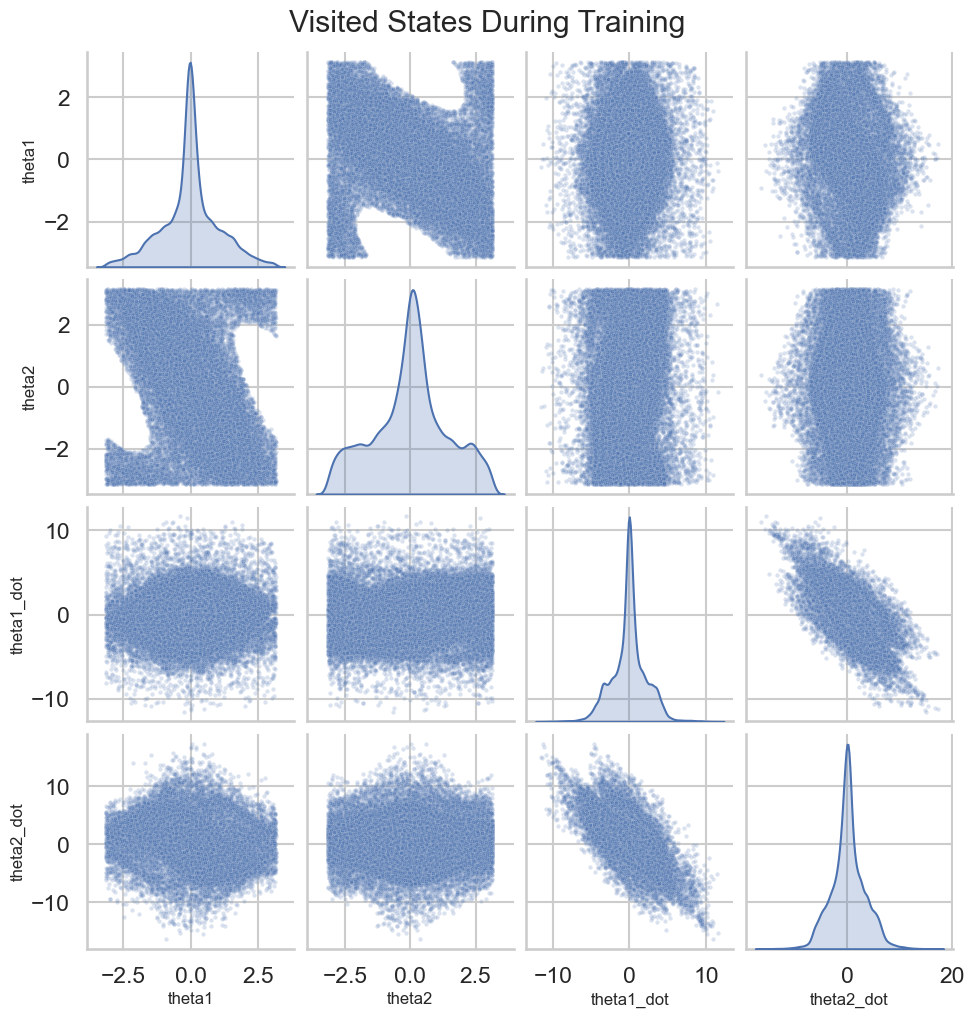

In [48]:
plot_learning_curve(ppo_rewards)
plot_value_function(ppo_agent, state_dim, action_dim)
plot_pg_policy(ppo_agent, state_dim)
plot_visited_states(ppo_visited_states)

In [49]:
interactive_ac_plots(ppo_agent, state_dim)

interactive(children=(FloatSlider(value=0.0, description='v1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

In [50]:
# Now that the agent is trained, we can visualize its behavior in the environment.
# env = gym.make('Acrobot-v1', render_mode="human")
# visualize_agent(ppo_agent, env)
# env.close()


::: {.callout-tip appearance="default"}
### Experiment: Effect of PPO architecture and training parameters on performance

In addition to the type of experiments we described above for the other agents, PPO has one new hyperparameter that you can experiment with to see how it affects learning:

- **Clipping Parameter ($\epsilon$)**: Experiment with different values of the clipping parameter $\epsilon$. A smaller $\epsilon$ leads to more conservative updates, which can improve stability but may slow down learning. Conversely, a larger $\epsilon$ allows for more aggressive updates, which can speed up learning but may also lead to instability. Try values like 0.1, 0.2, and 0.3 and observe how they affect the learning curve and the learned policy.

:::



## Summary and Next Steps

We saw above two related paradigms for solving reinforcement learning problems: value-based methods (DQN) and policy-based methods (REINFORCE), plus a merger of the two approaches in Actor-Critic and PPO. Each has its own strengths and weaknesses, and the choice of which to use often depends on the specific characteristics of the problem at hand, such as the nature of the action space (discrete vs. continuous), the complexity of the environment, and the desired trade-off between exploration and exploitation. Specifically:

- **Value-Based Methods (DQN)**: These methods are effective for discrete action spaces and can leverage the power of value functions to guide exploration. However, they can struggle with stability and convergence, especially in high-dimensional state spaces or continuous action spaces.
- **Policy-Based Methods (REINFORCE)**: These methods can naturally handle continuous action spaces and stochastic policies, making them more flexible in certain environments. However, they can suffer from high variance in their gradient estimates, which can slow down learning.
- **Actor-Critic Methods**: By combining value-based and policy-based approaches, Actor-Critic methods can reduce variance in policy updates while still allowing for direct optimization of the policy. However, they can still be sensitive to hyperparameters and require careful tuning.
- **Proximal Policy Optimization (PPO)**: PPO builds on Actor-Critic methods by introducing a clipped surrogate objective to limit the size of policy updates, improving stability and performance. It is widely used in practice due to its robustness and effectiveness across a variety of tasks. Like other policy-based methods, it can handle continuous action spaces and stochastic policies, which is one reason it is commonly used in Engineering and Robotics applications, where continuous control tasks are prevalent.

We could only cover this topic very briefly in this chapter, but there are many more advanced topics and techniques in reinforcement learning that are worth exploring. Some potential next steps include:

- **Exploring Advanced Algorithms**: Investigate more sophisticated RL algorithms such as Deep Deterministic Policy Gradient (DDPG), Twin Delayed DDPG (TD3), Soft Actor-Critic (SAC), and others that are designed for continuous action spaces and offer improved performance and stability.
- **Hierarchical Reinforcement Learning**: Study methods that decompose complex tasks into simpler subtasks, allowing for more efficient learning and transfer of knowledge across tasks.
- **Multi-Agent Reinforcement Learning**: Explore scenarios where multiple agents interact within the same environment, leading to challenges such as cooperation, competition, and communication.
- **Model-Based Reinforcement Learning**: Investigate approaches that learn a model of the environment to improve sample efficiency and planning capabilities.

All of these are active areas of research and have significant implications for real-world applications of reinforcement learning within Engineering and beyond.